c:\Users\Playdata\miniconda3\envs\ai_basic_env\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


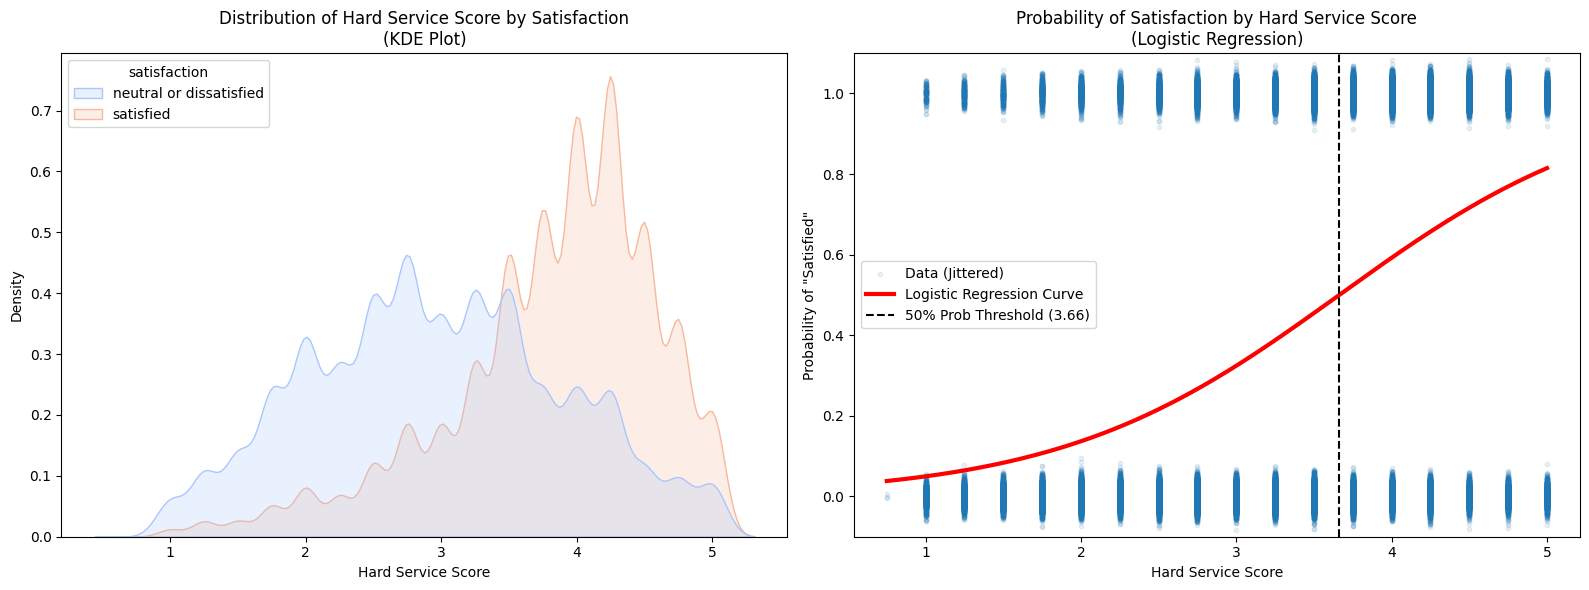

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from scipy.special import expit
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, roc_curve, classification_report
from sklearn.model_selection import train_test_split

df = pd.read_csv("../data/preprocessed_data.csv")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))


# Plot 1: KDE Plot
sns.kdeplot(data=df, x='Hard_Service_Score', hue='satisfaction', fill=True, 
            common_norm=False, palette='coolwarm', ax=axes[0])
axes[0].set_title('Distribution of Hard Service Score by Satisfaction\n(KDE Plot)')
axes[0].set_xlabel('Hard Service Score')
axes[0].set_ylabel('Density')

# Plot 2: Logistic Regression

X = df[['Hard_Service_Score']]
y = df['satisfaction_score']


clf = LogisticRegression()
clf.fit(X, y)

X_test = np.linspace(df['Hard_Service_Score'].min(), df['Hard_Service_Score'].max(), 300).reshape(-1, 1)
y_prob = clf.predict_proba(X_test)[:, 1]

y_jitter = y + np.random.normal(0, 0.02, size=len(y))

# Plot scatter
axes[1].scatter(df['Hard_Service_Score'], y_jitter, alpha=0.1, s=10, label='Data (Jittered)')

# Plot sigmoid curve
axes[1].plot(X_test, y_prob, color='red', linewidth=3, label='Logistic Regression Curve')

# Threshold line (0.5 probability)
# Solve for X where probability is 0.5: 1 / (1 + exp(-(mx + b))) = 0.5 => mx + b = 0 => x = -b/m
threshold_score = -clf.intercept_[0] / clf.coef_[0][0]
axes[1].axvline(x=threshold_score, color='black', linestyle='--', label=f'50% Prob Threshold ({threshold_score:.2f})')

axes[1].set_title('Probability of Satisfaction by Hard Service Score\n(Logistic Regression)')
axes[1].set_xlabel('Hard Service Score')
axes[1].set_ylabel('Probability of "Satisfied"')
axes[1].legend()
axes[1].set_ylim(-0.1, 1.1)

plt.tight_layout()

In [ ]:
def get_threshold(data, label="Global"):
    if len(data['satisfaction_score'].unique()) < 2:
        return None
    
    X = data[['Hard_Service_Score']]
    y = data['satisfaction_score']
    
    clf = LogisticRegression()
    clf.fit(X, y)
    
    
    threshold = -clf.intercept_[0] / clf.coef_[0][0]
    return threshold

# 1. Global Threshold
global_thresh = get_threshold(df, "Global")
print(f"Global Threshold: {global_thresh:.4f}")

# 2. Segment Thresholds
segments = {
    'Class': ['Business', 'Eco', 'Eco Plus'],
    'Type of Travel': ['Business travel', 'Personal Travel'],
    'Customer Type': ['Loyal Customer', 'disloyal Customer']
}

print("\n--- Segment Thresholds ---")
for col, values in segments.items():
    for val in values:
        subset = df[df[col] == val]
        thresh = get_threshold(subset, f"{col}={val}")
        print(f"{col} - {val}: {thresh:.4f}")

Global Threshold: 3.6629

--- Segment Thresholds ---
Class - Business: 2.9224
Class - Eco: 6.2343
Class - Eco Plus: 4.6447
Type of Travel - Business travel: 3.1615
Type of Travel - Personal Travel: 34.3858
Customer Type - Loyal Customer: 3.5192
Customer Type - disloyal Customer: 14.7230


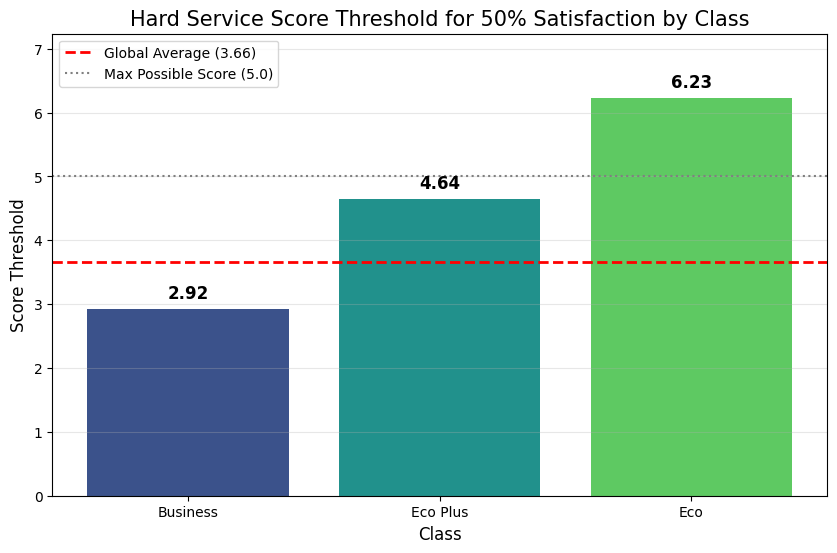

In [ ]:
classes = ['Business', 'Eco Plus', 'Eco']
thresholds = []
for cls in classes:
    subset = df[df['Class'] == cls]
    thresh = get_threshold(subset)
    thresholds.append(thresh)


plot_data = pd.DataFrame({
    'Class': classes,
    'Threshold': thresholds
})


plt.figure(figsize=(10, 6))


colors = ['#1f77b4', '#ff7f0e', '#d62728'] # Blue, Orange, Red-ish

bars = plt.bar(plot_data['Class'], plot_data['Threshold'], color=sns.color_palette("viridis", 3))

plt.axhline(y=global_thresh, color='red', linestyle='--', linewidth=2, label=f'Global Average ({global_thresh:.2f})')

plt.axhline(y=5.0, color='gray', linestyle=':', linewidth=1.5, label='Max Possible Score (5.0)')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
             f'{height:.2f}',
             ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.title('Hard Service Score Threshold for 50% Satisfaction by Class', fontsize=15)
plt.xlabel('Class', fontsize=12)
plt.ylabel('Score Threshold', fontsize=12)
plt.ylim(0, max(thresholds) + 1) # Set y-limit to accommodate the highest bar
plt.legend()
plt.grid(axis='y', alpha=0.3)

Accuracy: 0.7188
ROC-AUC: 0.7627
Confusion Matrix:
[[8832 2881]
 [2963 6105]]

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.75      0.75     11713
           1       0.68      0.67      0.68      9068

    accuracy                           0.72     20781
   macro avg       0.71      0.71      0.71     20781
weighted avg       0.72      0.72      0.72     20781



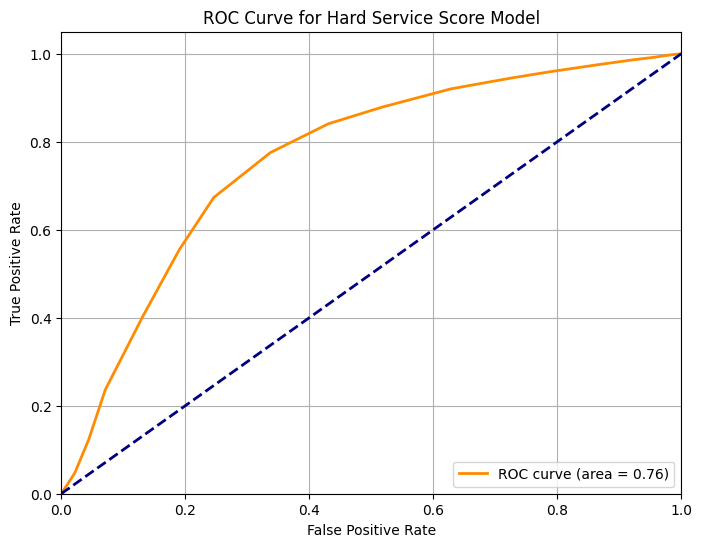

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit Model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Metrics
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
conf_matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")
print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(report)

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Hard Service Score Model')
plt.legend(loc="lower right")
plt.grid(True)